In [1]:
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 6.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import nltk
from sklearn.feature_extraction.text import CountVectorizer
import contractions
import string

from scipy.stats import uniform

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
DATA_DIR = '/content/drive/MyDrive/APS360 Group/Data/'
train = pd.read_csv(DATA_DIR+'train.csv').drop(columns=['Unnamed: 0'])

In [5]:
train.head()

,lyrics,mood_cats
0,a western sky is glowing calling off the day f...,2
1,baby dont you cry no more no more baby dont yo...,2
2,got a lotta heartache hes a fuckin weasel his ...,0
3,the snow is snowin wind is blowin but i can we...,0
4,you come to me with a casual flow and suddenly...,2


In [6]:
train['word_count'] = train['lyrics'].apply(lambda x: len(x.split()))

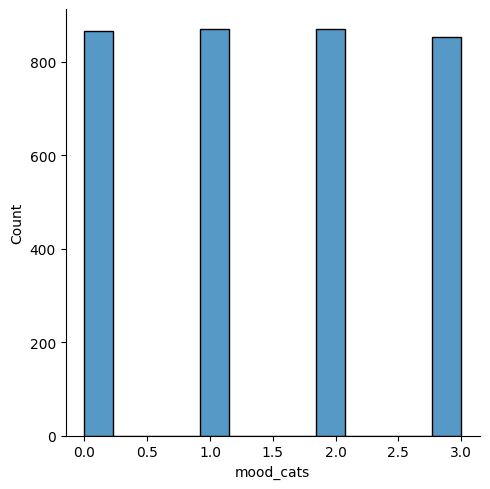

In [7]:
sns.displot(data=train, x='mood_cats')

A large amount more of happy songs but not extremely unbalanced

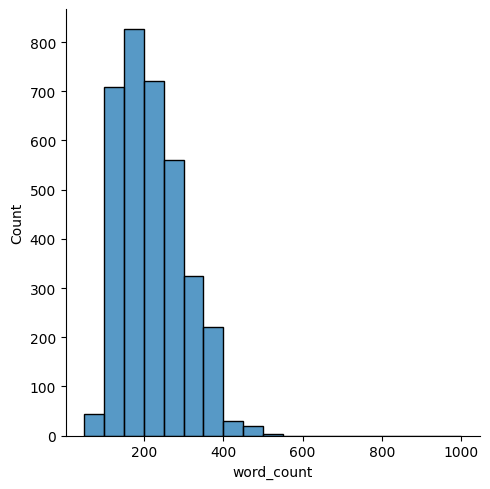

In [8]:
sns.displot(train, x='word_count', bins=[i*50 for i in range(1, 21)])

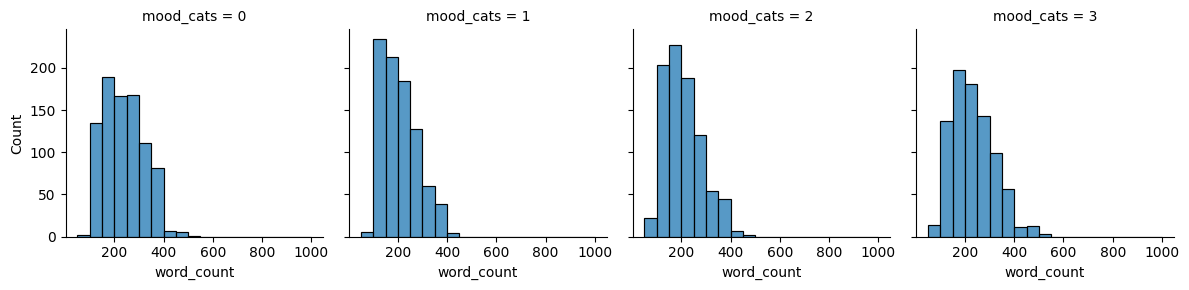

In [9]:
g = sns.FacetGrid(train, col='mood_cats')
g.map_dataframe(sns.histplot, x='word_count', bins=[i*50 for i in range(1, 21)])

In [10]:
train.drop(columns='word_count', inplace=True)

In [11]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
def remove_stop_words(df):
  df['lyrics'] = df['lyrics'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords]))

In [13]:
remove_stop_words(train)

In [14]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [15]:
word_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def remove_contractions(lyric):
  return ' '.join([contractions.fix(w) for w in word_tokenizer.tokenize(lyric)])

def remove_punctuation(lyric):
  out = []
  for c in lyric:
    if c in string.punctuation:
      continue
    out.append(c)
  return ''.join(out)


def lemmatize_lyric(lyric):
  out = []
  for word, tag in nltk.pos_tag(word_tokenizer.tokenize(lyric)):
    wntag = tag.lower()[0]
    wntag = wntag if wntag in {'a', 'r', 'n', 'v'} else None
    if not wntag:
      lemma = word
    else:
      lemma = lemmatizer.lemmatize(word,pos=wntag)
    out.append(lemma)
  return ' '.join(out)

In [16]:
train.head()

,lyrics,mood_cats
0,western sky glowing calling day fading rays li...,2
1,baby dont cry baby dont cry lot trouble wont b...,2
2,got lotta heartache hes fuckin weasel issues m...,0
3,snow snowin wind blowin weather storm care muc...,0
4,come casual flow suddenly defenses start go ta...,2


In [17]:
train['lyrics'] = train['lyrics'].apply(remove_contractions).apply(lemmatize_lyric)

In [18]:
vec = CountVectorizer(max_features=3000)
X_train = pd.DataFrame(vec.fit_transform(train['lyrics']).todense())
y_train = train['mood_cats']

In [19]:
test = pd.read_csv(DATA_DIR + 'test.csv').drop(columns='Unnamed: 0')
remove_stop_words(test)
test['lyrics'] = test['lyrics'].apply(remove_contractions).apply(lemmatize_lyric)
X_test = pd.DataFrame(vec.transform(test['lyrics']).todense())
y_test = train['mood_cats']

In [20]:
nb = MultinomialNB()
distributions = {'alpha' : uniform(loc=0, scale=4)}
rs_cv = RandomizedSearchCV(nb, distributions, scoring='accuracy', random_state=0, refit=True, cv=10)
rs_cv.fit(X_train, y_train)
accuracy_score(y_train, rs_cv.predict(X_train))

0.6711021116575066

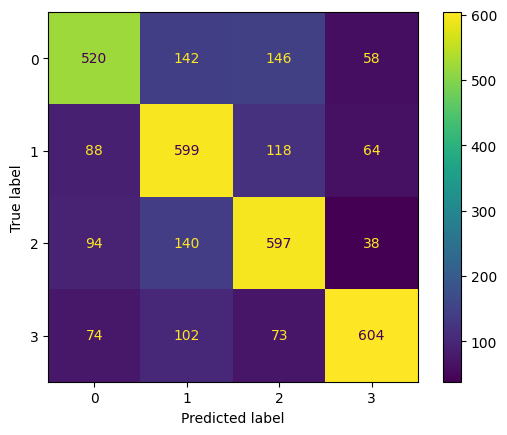

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix = confusion_matrix(y_train, rs_cv.predict(X_train))
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()